In [8]:
# Load various imports 
import pandas as pd
import os
import librosa
import librosa.display
from sklearn import preprocessing
import numpy as np
import IPython
import matplotlib as plt

In [9]:
from math import floor
path_train = 'data/train_labels.csv'
path_test = 'data/test_files.csv'
num_cc = 50
df = pd.read_csv(path_train)
total_count = len(df.index)
num_test = floor(total_count * 0.2)
df['filename'] = df['filename'].map(lambda x: 'data/data/%04d.wav' % x)
df_test_my = df.sample(num_test)
df = df[~df.index.isin(df_test_my.index)]
print(total_count)
print("Test size:")
print(num_test)
df.head(2)

1532
Test size:
306


,filename,pasture,height,label
0,data/data/0004.wav,alfalfa,tall,2
1,data/data/0009.wav,alfalfa,tall,2


In [10]:
IPython.display.Audio(df.loc[4]['filename'])

In [11]:
max_pad_len = 174

def extract_features(file_name):
    #audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
    y, sr = librosa.load(file_name, mono=True, duration=30)
    #mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=num_cc)
    #mfccs = librosa.util.normalize(mfccs)
    #pad_width = max_pad_len - mfccs.shape[1]
    #mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
            
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
    spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
    spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    zcr = librosa.feature.zero_crossing_rate(y)
    mfcc = librosa.feature.mfcc(y=y, sr=sr)

    return (mfccs,chroma_stft,spec_cent,spec_bw,rolloff)


In [5]:

features = []
for k,row in df.iterrows():
    class_label = row["label"]
    mfccs,chroma_stft,spec_cent,spec_bw,rolloff = extract_features(row['filename'])
    #data = librosa.util.normalize(data)
    features.append([mfccs,chroma_stft,spec_cent,spec_bw,rolloff, class_label])
columns = ['mfccs','chroma_stft','spec_cent','spec_bw','rolloff','class_label']
df_features = pd.DataFrame(features, columns=)
print('Finished feature extraction from ', len(df_features), ' files')
df_features.head(2)

Finished feature extraction from  1226  files


,feature,class_label
0,"[[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1...",2
1,"[[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1...",1


In [12]:
df_features.loc[0].feature.shape

(50, 174)

In [15]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# Convert features and corresponding classification labels into numpy arrays
X = np.array(df_features.feature.tolist())
y = np.array(df_features.class_label.tolist())

# Encode the classification labels
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y)) 

# split the dataset 
from sklearn.model_selection import train_test_split 
num_rows = num_cc
num_columns = max_pad_len
num_channels = 1

x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state = 42)
x_train = x_train.reshape(x_train.shape[0], num_rows, num_columns, num_channels)
x_test = x_test.reshape(x_test.shape[0], num_rows, num_columns, num_channels)

#x_train = np.expand_dims(x_train, axis=2)
#x_test = np.expand_dims(x_test, axis=2)



Using TensorFlow backend.


In [50]:
#x_train = np.expand_dims(x_train, axis=2)
#x_test = np.expand_dims(x_test, axis=2)


In [16]:
x_train.shape

(980, 50, 174, 1)

In [19]:
def build_model():
    global x_train
    num_labels = yy.shape[1]
    global x_test
    global y_train
    global y_test
    import numpy as np
    from keras.models import Sequential
    from keras.layers import Dense, Dropout, Activation, Flatten
    from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
    from keras.optimizers import Adam
    from keras.utils import np_utils
    from sklearn import metrics 
    import keras

    model = Sequential()

    input_shape = (x_train.shape[1],x_train.shape[2],1)
    model.add(Conv2D(filters=16, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.25))

    model.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.25))

    model.add(Conv2D(filters=64,kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.25))


    model.add(Flatten())
    model.add(Dense(150, activation='relu'))
    model.add(Dense(num_labels, activation='softmax'))

    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

    return model


In [53]:

def build_model2(dropout=0.2, kernel_size=3, pool_size=2, optimizer='adam'):
    global x_train
    global x_test
    global y_train
    global y_test
    import numpy as np
    from keras.models import Sequential
    from keras.layers import Dense, Dropout, Activation, Flatten
    from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
    from keras.optimizers import Adam
    from keras.utils import np_utils
    from sklearn import metrics 
    import keras
    num_rows = num_cc
    num_columns = max_pad_len
    num_channels = 1


    num_labels = yy.shape[1]

   
    # Construct model 
    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=3, input_shape=(num_rows, num_columns, num_channels), activation='relu'))
    model.add(Dropout(0.2))
    model.add(MaxPooling2D(pool_size=2))
    

    model.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
    model.add(Dropout(0.2))
    model.add(MaxPooling2D(pool_size=2))
    
    
    model.add(GlobalAveragePooling2D())


    model.add(Dense(num_labels, activation='softmax'))
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

    return model

In [54]:

def build_model22(dropout=0.2, kernel_size=3, pool_size=2, optimizer='adam'):
    global x_train
    global x_test
    global y_train
    global y_test
    import numpy as np
    from keras.models import Sequential
    from keras.layers import Dense, Dropout, Activation, Flatten
    from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
    from keras.optimizers import Adam
    from keras.utils import np_utils
    from sklearn import metrics 
    import keras
    num_rows = num_cc
    num_columns = max_pad_len
    num_channels = 1


    num_labels = yy.shape[1]

   
    # Construct model 
    model = Sequential()
    model.add(Conv2D(filters=16, kernel_size=2, input_shape=(num_rows, num_columns, num_channels), activation='relu'))
    model.add(Dropout(0.2))
    model.add(MaxPooling2D(pool_size=2))
    

    model.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
    model.add(Dropout(0.2))
    model.add(MaxPooling2D(pool_size=2))
    
    
    model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
    model.add(Dropout(0.2))
    model.add(MaxPooling2D(pool_size=2))
    
    
    model.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
    model.add(Dropout(0.2))
    model.add(MaxPooling2D(pool_size=2))
    
    
    model.add(GlobalAveragePooling2D())

    model.add(Dense(num_labels, activation='softmax'))
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

    return model

In [55]:
def build_model3():
    global x_train
    global x_test
    global y_train
    global y_test
    import numpy as np
    from keras.models import Sequential
    from keras.layers import Dense, Dropout, Activation, Flatten
    from keras.layers import Convolution1D, Conv1D, MaxPooling1D, GlobalAveragePooling1D
    from keras.layers import BatchNormalization
    from keras.optimizers import Adam
    from keras.utils import np_utils
    from sklearn import metrics 
    import keras
    num_labels = yy.shape[1]

    model = Sequential()
    model.add(Conv1D(64, 2,padding='same',input_shape=(x_train.shape[1],x_train.shape[2])))
    
    model.add(Activation('relu'))
    model.add(Conv1D(64, 2,padding='same'))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=(2)))
    
    model.add(Conv1D(128, 3,padding='same',))
    model.add(Activation('relu'))
    model.add(Conv1D(128, 3,padding='same',))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=(2)))
    
    model.add(Conv1D(128, 3,padding='same',))
    model.add(Activation('relu'))
    model.add(Conv1D(128, 3,padding='same',))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=(2)))
    
    model.add(Conv1D(128, 3,padding='same',))
    model.add(Activation('relu'))
    model.add(Conv1D(128, 3,padding='same',))
    model.add(Activation('relu'))
    
    model.add(Dropout(0.5))
    model.add(GlobalAveragePooling1D())
    
    model.add(Dense(num_labels, activation='softmax'))

    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

    return model


In [20]:
model = build_model()
# Display model architecture summary 
model.summary()
# Calculate pre-training accuracy 
score = model.evaluate(x_test, y_test, verbose=1)
accuracy = 100*score[1]
print("Pre-training accuracy: %.4f%%" % accuracy) 


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 172, 16)       160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 86, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 86, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 84, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 11, 42, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 11, 42, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 9, 40, 64)        

In [21]:
import keras
from IPython.display import clear_output
import numpy as np
import matplotlib.pyplot as plt

class LivePlot(keras.callbacks.Callback):
    
    # This function is called when the training begins
    def on_train_begin(self, logs={}):
        # Initialize the lists for holding the logs, losses and accuracies
        self.losses = []
        self.acc = []
        self.val_losses = []
        self.val_acc = []
        self.logs = []
    
    # This function is called at the end of each epoch
    def on_epoch_end(self, epoch, logs={}):
        
        # Append the logs, losses and accuracies to the lists
        self.logs.append(logs)
        self.losses.append(logs.get('loss'))
        self.acc.append(logs.get('acc'))
        self.val_losses.append(logs.get('val_loss'))
        self.val_acc.append(logs.get('val_acc'))
        # Before plotting ensure at least 2 epochs have passed
        if len(self.losses) > 1:
            
            # Clear the previous plot
            clear_output(wait=True)
            N = np.arange(0, len(self.losses))
            
            # You can chose the style of your preference
            # print(plt.style.available) to see the available options
            plt.style.use("seaborn")
            
            # Plot train loss, train acc, val loss and val acc against epochs passed
            plt.figure()
            plt.plot(N, self.losses, label = "train_loss")
            plt.plot(N, self.acc, label = "train_acc")
            plt.plot(N, self.val_losses, label = "val_loss")
            plt.plot(N, self.val_acc, label = "val_acc")
            plt.title("Training Loss and Accuracy [Epoch {}]".format(epoch))
            plt.xlabel("Epoch #")
            plt.ylabel("Loss/Accuracy")
            plt.legend()
            plt.show()


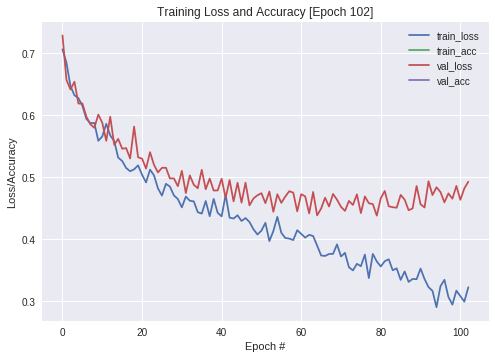

Epoch 104/250


In [ ]:
#https://medium.com/@mikesmales/sound-classification-using-deep-learning-8bc2aa1990b7
from keras.callbacks import EarlyStopping, ModelCheckpoint
from datetime import datetime 

num_epochs = 250
num_batch_size = 150

es = EarlyStopping(monitor='val_loss', patience=30)
ch = ModelCheckpoint(filepath='data/weights.best.basic_cnn.hdf5', 
                               verbose=1, save_best_only=True)


callbacks = [es, ch, LivePlot()]
start = datetime.now()

model.fit(x_train, y_train, batch_size=num_batch_size, 
          epochs=num_epochs, 
          validation_data=(x_test, y_test), 
          verbose=1,
          callbacks=callbacks)


duration = datetime.now() - start
print("Training completed in time: ", duration)


In [ ]:
path_weights = 'data/weights.best.basic_cnn.hdf5'
model.load_weights(path_weights)

# Evaluating the model on the training and testing set
score_t = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score_t[1])

score_v = model.evaluate(x_test, y_test, verbose=0)
print("Val Accuracy: ", score_v[1])


features = []
for k,row in df_test_my.iterrows():
    data = extract_features(row['filename'])
    features.append([data])
df_features_test = pd.DataFrame(features, columns=['feature'])
print('Finished feature extraction from ', len(df_features_test), ' files')
X_test_my = np.array(df_features_test.feature.tolist())
x_test_my = X_test_my.reshape(X_test_my.shape[0], num_rows, num_columns, num_channels)

le = LabelEncoder()
y_test_my = df_test_my.label.tolist()
Y_test_my = to_categorical(le.fit_transform(y_test_my)) 

#X_test_my = np.expand_dims(X_test_my, axis=2)

# Evaluating the model on the training and testing set
score_test = model.evaluate(x_test_my, Y_test_my, verbose=0)
print("Test Accuracy: ", score_test[1])


In [64]:
df_test_ = pd.read_csv(path_test)
df_test = df_test_.copy()
df_test['filename'] = df_test['filename'].map(lambda x: 'data/data/%04d.wav' % x)
print(len(df_test.index))
df_test.head(2)

1551


,filename
0,data/data/0001.wav
1,data/data/0002.wav


In [65]:
features = []
for k,row in df_test.iterrows():
    data = extract_features(row['filename'])
    features.append([data])
df_features_test = pd.DataFrame(features, columns=['feature'])
print('Finished feature extraction from ', len(df_features_test), ' files')


Finished feature extraction from  1551  files


In [66]:
X_test = np.array(df_features_test.feature.tolist())
X_test = X_test.reshape(X_test.shape[0], num_rows, num_columns, num_channels)

In [67]:
y_prob = model.predict(X_test)
y_classes = y_prob.argmax(axis=-1)


In [68]:
len(X_test)

1551

In [69]:
y_classes

array([0, 0, 0, ..., 1, 1, 1])

In [70]:
df_test_['label'] = y_classes

In [71]:
from datetime import datetime
now = datetime.now() # current date and time
timestamp = now.strftime("%Y%m%d_%H%M%S")
model_json = model.to_json()
model.save_weights('data/%s_weights.hdf5' % timestamp)
with open("data/%s_model.json" % timestamp, "w") as json_file:
    json_file.write(model_json)
df_test_.to_csv('data/%s_res.csv' % timestamp, index=None, header=None)
with open("data/%s_score.txt" % timestamp, "w") as file:
    scoring = "validation acc: %f - training acc: %f - test acc %f:" % (score_v[1], score_t[1], score_test[1])
    file.write(scoring)

timestamp

'20191115_091534'